# Introduction

In this article, we will build a denoising autoencoder (DAE) for tabular data. Although, the main idea of autoencoders came from image processing domain, we can use this concept for tabular datasets as well. This can be applied to tasks such as data denoising, data compression, anomaly detection, and feature extraction. Here we will use DAE for data compression. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV

from dataset.get_data import get_dataloaders
from model.tab_dae import DenoisingAutoencoder

import warnings

warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("dataset/MNIST/train.csv.zip")
test = pd.read_csv("dataset/MNIST/test.csv.zip")

In [3]:
train.shape

(42000, 785)

In [4]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train.columns = list(range(0,785)) # 0th index is always represents the label, rest is pixle values
test.columns = list(range(1,785)) #since test data doesnot contain label this should be `range(1,784)

Let's define our train and validation datasets, first I need to define `X` and `y` from the train data

In [6]:
X = train[list(range(1,785))]
y = train[0]

Since MNIST dataset pixel value range is 0-255 I want to normalize it 0-1 range. Since this is pixele value, I can simply devide all values by `255`

In [7]:
X = X / 255

## Model architecture

An autoencoder is a type of neural network that is designed to reconstruct its input data after encoding it through a series of hidden layers. In the context of tabular data, an autoencoder can be used to reduce the dimensionality of the data by learning a compact representation of the input features.

A typical autoencoder architecture for tabular data consists of an encoder and a decoder. The encoder takes the input data and maps it to a lower-dimensional latent space through a series of dense layers, while the decoder tries to reconstruct the original data from the latent representation. Since autoencoder is deep neural network, It can learn complex relationships. As an result, the latent layer of autoencoder represents the comact and complex representation of the original feature vector. The encoder and decoder are trained jointly, with the goal of minimizing the reconstruction error between the input and the reconstructed data.

One common use case for autoencoders on tabular data is as a preprocessing step for classification or regression tasks. By reducing the dimensionality of the data, the autoencoder can help to eliminate noise and improve the generalization ability of the downstream model. Autoencoders can also be used for data denoising, anomaly detection, and data compression.

<img src='images/Architecture.png'>

One of the main points note here is, used loss function. Here I have used MSE loss. It's one of the common choices for the loss function in an autoencoder, as it measures the difference between the predicted and actual values by taking the average of the squared differences. It is typically used when the input data is continuous, as it can provide a good balance between large and small errors.

Here is the mathematical formulation of the MSE loss:

MSE = $\frac{1}{n} \sum\limits_{i=1}^{n} (y_{pred} - y)^2$

where n is the number of samples in the data, y_pred is the predicted value, and y is the true value.

The MSE loss has several properties that make it a good choice for autoencoders:

- It is differentiable, which means that it can be used with gradient descent-based optimization algorithms.
- It is sensitive to large errors, as the squared difference between the predicted and true values will be much larger for large errors than for small ones. This helps to encourage the model to focus on minimizing large errors, which can be important for ensuring good reconstruction quality.
- It is relatively simple to compute and interpret, as it returns a single scalar value that can be used to measure the overall reconstruction error.

While the MSE loss is a popular choice for autoencoders, it is not the only option. Depending on the specific needs of the task, other loss functions such as the mean absolute error (MAE) or the binary cross-entropy (BCE) may also be used.

In [14]:
# Split the data into train and test sets
train_data, test_data = train_test_split(train, test_size=0.2)

train_data,test_data,train_labels,test_labels = train_data.loc[:,1:], test_data.loc[:,1:], train_data.loc[:,0], test_data.loc[:,0]

# Convert the data to a PyTorch tensor
train_data = torch.tensor(train_data.values/255).float()
test_data = torch.tensor(test_data.values/255).float()

# Define the model, optimizer, and loss function
input_dim = X.shape[1]
encoding_dim = 10
hidden_dims = [256, 128, 64, 32]
model = DenoisingAutoencoder(input_dim, hidden_dims, encoding_dim)
optimizer = optim.Adam(model.parameters(),lr=1e-2)
loss_fn = nn.MSELoss()

# Train the model
batch_size = 10000
num_epochs = 10
for epoch in range(num_epochs):
    # Iterate over the training data in batches
    for i in range(0, len(train_data), batch_size):
        inputs = train_data[i:i+batch_size]
        # Forward pass
        output = model(inputs, add_noise=True)
        loss = loss_fn(output, inputs)
        
        # Backward pass and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Evaluate the model on the test set
    model.eval()
    
    test_loss = 0
    for i in range(0, len(test_data), batch_size):
        inputs = test_data[i:i+batch_size]
        output = model(inputs, add_noise=False)
        test_loss += loss_fn(output, inputs).item()
    test_loss /= len(test_data)
    print(f'Test loss: {test_loss:.5f}')
    
# switch back to train mode    
    model.train()

Test loss: 0.00003
Test loss: 0.00003
Test loss: 0.00002
Test loss: 0.00002
Test loss: 0.00002
Test loss: 0.00002
Test loss: 0.00002
Test loss: 0.00002
Test loss: 0.00001
Test loss: 0.00001


In [15]:
model

DenoisingAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=64, out_features=32, bias=True)
    (13): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.2, inplace=False)
    (16): Linear(in_features=32, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, ou

## Let's plot the model learned representation of the data

For getting latent represention of the data, we have to use encoder part of the model. Because encoder was trained to extracting meaningfull information from original feature vector.

In [16]:
latent_repr_test = model.encoder(test_data)#use encoder for getting low-dimentional data
latent_repr_train = model.encoder(train_data)#use encoder for getting low-dimentional data

In [17]:
latent_repr_train = latent_repr_train.detach().numpy() #convert into numpy ndarray
latent_repr_test = latent_repr_test.detach().numpy() #convert into numpy ndarray

## Let's plot the learnt data distrubution

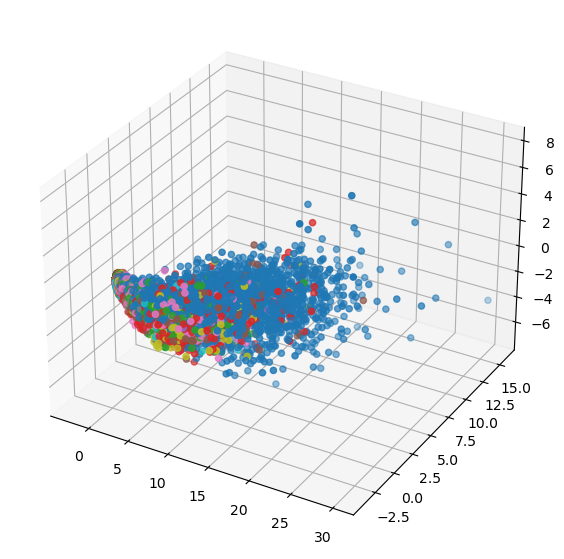

In [18]:
# Perform PCA on the data
pca = PCA(n_components=3)  # Keep all 3 principal components
pca_data = pca.fit_transform(latent_repr_train)  # Shape: (num_samples, 3)

# Define the hue values and create a color map
hue_values = train_labels  # Array of length num_samples with the hue values for each sample
unique_hue_values = np.unique(hue_values)  # Array of unique hue values
num_colors = len(unique_hue_values)  # Number of unique hue values
color_map = ListedColormap(['C{}'.format(i) for i in range(num_colors)])  # Create a color map

# Create a 3D scatter plot using the scatter function from the mplot3d module
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_data[:, 0], pca_data[:, 1], pca_data[:, 2], c=hue_values, cmap=color_map)
plt.show()

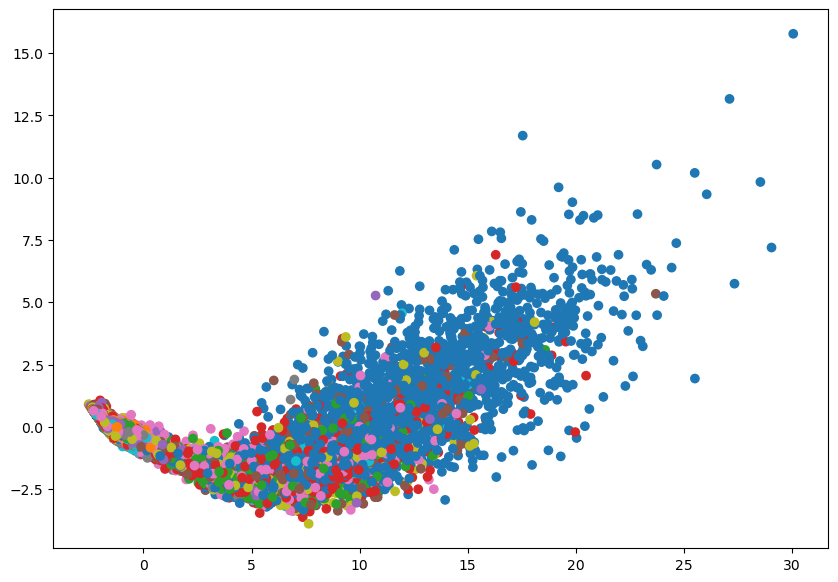

In [19]:
pca = PCA(n_components=2)  # Keep all 2 principal components
pca_data = pca.fit_transform(latent_repr_train)  # Shape: (num_samples, 2)

# Define the hue values and create a color map
hue_values = train_labels  # Array of length num_samples with the hue values for each sample
unique_hue_values = np.unique(hue_values)  # Array of unique hue values
num_colors = len(unique_hue_values)  # Number of unique hue values
color_map = ListedColormap(['C{}'.format(i) for i in range(num_colors)])  # Create a color map

# Create a 3D scatter plot using the scatter function from the mplot3d module
fig = plt.figure(figsize=(10,7))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=hue_values, cmap=color_map)
plt.show()

In [27]:
#getting the data converted into numpy ndarray
train_data_npy,test_data_npy = train_data.detach().numpy(),test_data.detach().numpy()

# Define the target values
target_train = train_labels  # Array of length num_train_samples with the target values for the training data
target_test = test_labels  # Array of length num_test_samples with the target values for the test data

pca = PCA(n_components=2)  # Keep all 2 principal components
train_data_npy_pca = pca.fit_transform(train_data_npy)  # Shape: (num_samples, 2)
test_data_npy_pca = pca.transform(test_data_npy) #Shape: (num_samples, 2)

In [28]:
%%time

# Create the logistic regression model with cross-validation
lr = LogisticRegressionCV(cv=5)

# Train the model on the training data
lr.fit(train_data_npy_pca, target_train)

# Make predictions on the test data
predictions = lr.predict(test_data_npy_pca)

# Calculate evaluation metrics for each class
report = classification_report(target_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.65      0.78      0.71       881
           1       0.83      0.95      0.89       963
           2       0.22      0.10      0.14       829
           3       0.43      0.64      0.51       867
           4       0.39      0.40      0.39       869
           5       0.22      0.01      0.02       721
           6       0.32      0.43      0.37       800
           7       0.42      0.64      0.51       892
           8       0.24      0.27      0.25       761
           9       0.28      0.13      0.17       817

    accuracy                           0.45      8400
   macro avg       0.40      0.43      0.40      8400
weighted avg       0.41      0.45      0.41      8400

Wall time: 34.4 s


## Let's try one more time with latent representation of the data

In [29]:
%%time

# Create the logistic regression model with cross-validation
lr = LogisticRegressionCV(cv=5)

# Train the model on the training data
lr.fit(latent_repr_train, target_train)

# Make predictions on the test data
predictions = lr.predict(latent_repr_test)

# Calculate evaluation metrics for each class
report = classification_report(target_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.67      0.66      0.66       881
           1       0.34      0.71      0.46       963
           2       0.17      0.11      0.13       829
           3       0.36      0.19      0.25       867
           4       0.17      0.01      0.02       869
           5       0.00      0.00      0.00       721
           6       0.29      0.07      0.12       800
           7       0.24      0.37      0.29       892
           8       0.15      0.53      0.24       761
           9       0.15      0.06      0.08       817

    accuracy                           0.28      8400
   macro avg       0.25      0.27      0.23      8400
weighted avg       0.26      0.28      0.23      8400

Wall time: 1min 24s
